# Imports

In [1]:
import pyarrow as pa
import pyarrow.parquet as pq

import pandas as pd

import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
from ipywidgets import interact, fixed
import numpy as np

from scipy.stats import pearsonr, spearmanr

import geopandas as gpd #heatmap
import plotly.graph_objects as go
import plotly.io as pio

import json
from functools import partial

from matplotlib.colors import TwoSlopeNorm

In [2]:
MRD = 10**9

# Data loading

### BTC data

In [3]:
btc_price_data = pd.read_csv("data/BTC_ALL_graph_coinmarketcap.csv",sep=";")

#split off time of day
btc_price_data["timestamp"] = btc_price_data["timestamp"].apply(lambda x: str(x).split("T")[0]) 
btc_price_data = btc_price_data[["high", "timestamp"]]
btc_price_data.rename(columns={"timestamp": "date"}, inplace=True)


btc_price_data["year"] = btc_price_data["date"].apply(lambda x: int(str(x).split("-")[0]))

btc_price_data = btc_price_data[btc_price_data['year'] >= 2011]

display(btc_price_data.tail())

,high,date,year
726,26550.072937,2023-05-04,2023
727,25148.010374,2023-05-11,2023
728,25338.472061,2023-05-17,2023
729,25279.405768,2023-05-24,2023
730,26131.181703,2023-05-30,2023


### Actors data

In [4]:
actors = pq.read_table("data/actors.parquet")
actors_df = actors.to_pandas()

actors_df

,id,uri,label,jurisdictions,categories
0,bilaxy,bilaxy.com,Bilaxy,HK,exchange
1,banxa,banxa.com,Banxa,"AU, NL, US",exchange
2,aax,www.aax.com,Aax,SC,exchange
3,altcointrader,www.altcointrader.co.za,AltcoinTrader,ZA,exchange
4,azbit,azbit.com,Azbit,MH,exchange
...,...,...,...,...,...
309,stocksexchange,stex.com,Stex,EE,exchange
310,smenarnabitcoin,smenarnabitcoin.cz,Smenarnabitcoin,CZ,exchange
311,xapo,xapo.com,Xapo,US,"exchange, service"
312,yobit,yobit.net,YoBit,RU,exchange


### Flow data

In [5]:
flows = pq.read_table("data/flows.parquet")
flows_df = flows.to_pandas()

flows_df

,src_id,dst_id,value_asset,value_USD,date
0,1coin,1coin,36870000,243.755870,2014-03-03
1,1coin,1coin,380120000,2378.899210,2014-03-10
2,1coin,1coin,429150403,2738.687542,2014-03-13
3,1coin,1coin,333900098,2092.574397,2014-03-14
4,1coin,1coin,779334803,4938.373652,2014-03-15
...,...,...,...,...,...
1939582,zyado,zyado,1019592,11.368847,2017-03-21
1939583,zyado,zyado,1004152,13.325487,2017-04-29
1939584,zyado,zyado,39850720,5966.967603,2018-01-10
1939585,zyado,zyado,19251202,1730.115174,2018-04-27


### Country Codes

In [6]:
# Load country codes (source: https://github.com/lukes/ISO-3166-Countries-with-Regional-Codes)
country_codes = pd.read_csv('data/country_codes.csv')

display(country_codes.head())

,name,alpha-2,alpha-3,country-code,iso_3166-2,region,sub-region,intermediate-region,region-code,sub-region-code,intermediate-region-code
0,Afghanistan,AF,AFG,4,ISO 3166-2:AF,Asia,Southern Asia,NaN,142.0,34.0,NaN
1,Åland Islands,AX,ALA,248,ISO 3166-2:AX,Europe,Northern Europe,NaN,150.0,154.0,NaN
2,Albania,AL,ALB,8,ISO 3166-2:AL,Europe,Southern Europe,NaN,150.0,39.0,NaN
3,Algeria,DZ,DZA,12,ISO 3166-2:DZ,Africa,Northern Africa,NaN,2.0,15.0,NaN
4,American Samoa,AS,ASM,16,ISO 3166-2:AS,Oceania,Polynesia,NaN,9.0,61.0,NaN


### GDP Data

In [7]:
# Load GDP data (Source: https://data.worldbank.org/indicator/NY.GDP.MKTP.CD)
gdp = pd.read_csv('data/gdp.csv', skiprows=3)
gdp_meta = pd.read_csv('data/gdp_meta.csv')

display(gdp.head())
display(gdp_meta.head())

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,Unnamed: 67
0,Aruba,ABW,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,2.791061e+09,2.963128e+09,2.983799e+09,3.092179e+09,3.202235e+09,3.368970e+09,2.610039e+09,3.126019e+09,NaN,NaN
1,Africa Eastern and Southern,AFE,GDP (current US$),NY.GDP.MKTP.CD,2.129152e+10,2.180944e+10,2.370806e+10,2.821128e+10,2.611994e+10,2.968348e+10,...,1.003403e+12,9.231439e+11,8.898593e+11,1.030482e+12,1.016697e+12,1.009052e+12,9.341791e+11,1.089454e+12,NaN,NaN
2,Afghanistan,AFG,GDP (current US$),NY.GDP.MKTP.CD,5.377778e+08,5.488889e+08,5.466667e+08,7.511112e+08,8.000000e+08,1.006667e+09,...,2.055058e+10,1.999816e+10,1.801956e+10,1.889635e+10,1.841885e+10,1.890449e+10,2.014344e+10,1.478686e+10,NaN,NaN
3,Africa Western and Central,AFW,GDP (current US$),NY.GDP.MKTP.CD,1.040414e+10,1.112789e+10,1.194319e+10,1.267633e+10,1.383837e+10,1.486223e+10,...,8.924979e+11,7.669580e+11,6.905454e+11,6.837480e+11,7.663597e+11,7.947191e+11,7.847997e+11,8.401873e+11,NaN,NaN
4,Angola,AGO,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,1.372444e+11,8.721930e+10,4.984049e+10,6.897277e+10,7.779294e+10,6.930911e+10,5.361907e+10,6.740429e+10,NaN,NaN


,Country Code,Region,IncomeGroup,SpecialNotes,TableName,Unnamed: 5
0,ABW,Latin America & Caribbean,High income,NaN,Aruba,NaN
1,AFE,NaN,NaN,"26 countries, stretching from the Red Sea in t...",Africa Eastern and Southern,NaN
2,AFG,South Asia,Low income,The reporting period for national accounts dat...,Afghanistan,NaN
3,AFW,NaN,NaN,"22 countries, stretching from the westernmost ...",Africa Western and Central,NaN
4,AGO,Sub-Saharan Africa,Lower middle income,The World Bank systematically assesses the app...,Angola,NaN


### Overall BTC Trading Volume

In [8]:
trading_volume = pd.read_csv('data/bitcoin_trading_volume.csv')
trading_volume.Time = pd.to_datetime(trading_volume.Time)
trading_volume['year'] = trading_volume.Time.dt.year

display(trading_volume)

,Time,price,volume,year
0,2010-07-01 00:00:00+00:00,0.064460,1.966753e+03,2010
1,2010-08-01 00:00:00+00:00,0.064572,1.428969e+04,2010
2,2010-09-01 00:00:00+00:00,0.061903,1.344608e+04,2010
3,2010-10-01 00:00:00+00:00,0.108899,1.173847e+05,2010
4,2010-11-01 00:00:00+00:00,0.258841,2.237274e+05,2010
...,...,...,...,...
150,2023-01-01 00:00:00+00:00,20415.513027,2.299786e+10,2023
151,2023-02-01 00:00:00+00:00,23743.338494,1.333384e+10,2023
152,2023-03-01 00:00:00+00:00,25618.094071,2.468627e+10,2023
153,2023-04-01 00:00:00+00:00,29181.453834,1.686690e+10,2023


## Juri names Long


In [9]:
with open('data/country_names_long.json', 'r') as file:
    juri_names_long = json.load(file)

for name in juri_names_long:
    if len(name) > 15:
        name = name[:15]+"."

### Population data

In [10]:
# Load Population data (Source: https://data.worldbank.org/indicator/SP.POP.TOTL)
population = pd.read_csv('data/population.csv', skiprows=3)

display(population.head())

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,Unnamed: 67
0,Aruba,ABW,"Population, total",SP.POP.TOTL,54608.0,55811.0,56682.0,57475.0,58178.0,58782.0,...,103594.0,104257.0,104874.0,105439.0,105962.0,106442.0,106585.0,106537.0,NaN,NaN
1,Africa Eastern and Southern,AFE,"Population, total",SP.POP.TOTL,130692579.0,134169237.0,137835590.0,141630546.0,145605995.0,149742351.0,...,583650827.0,600008150.0,616377331.0,632746296.0,649756874.0,667242712.0,685112705.0,702976832.0,NaN,NaN
2,Afghanistan,AFG,"Population, total",SP.POP.TOTL,8622466.0,8790140.0,8969047.0,9157465.0,9355514.0,9565147.0,...,32716210.0,33753499.0,34636207.0,35643418.0,36686784.0,37769499.0,38972230.0,40099462.0,NaN,NaN
3,Africa Western and Central,AFW,"Population, total",SP.POP.TOTL,97256290.0,99314028.0,101445032.0,103667517.0,105959979.0,108336203.0,...,397855507.0,408690375.0,419778384.0,431138704.0,442646825.0,454306063.0,466189102.0,478185907.0,NaN,NaN
4,Angola,AGO,"Population, total",SP.POP.TOTL,5357195.0,5441333.0,5521400.0,5599827.0,5673199.0,5736582.0,...,27128337.0,28127721.0,29154746.0,30208628.0,31273533.0,32353588.0,33428486.0,34503774.0,NaN,NaN


### Tax Haven data

In [11]:
# Load tax haven data (Source: https://www.taxjustice.net)
cthi_2021 = pd.read_csv('data/cthi_2021.csv', sep=';')[['Country', 'Haven Score']]
cthi_2019 = pd.read_csv('data/cthi_2019.csv', sep=';')[['Country', 'Haven Score']]
cthi_2019['Haven Score'] = cthi_2019['Haven Score'].str.replace(',', '.').astype('float')
cthi_2021['Haven Score'] = cthi_2021['Haven Score'].str.replace(',', '.').astype('float')

# If both datapoints are available for a country we average over the 2021 and 2019 score

cthi = pd.merge(cthi_2019, cthi_2021, on='Country', how='outer')
print(f'Shape {cthi.shape[0]}')
cthi['Haven Score'] = cthi[['Haven Score_x', 'Haven Score_y']].mean(axis=1, skipna=True).fillna(0)
cthi.drop(columns=['Haven Score_x', 'Haven Score_y'], inplace=True)

display(cthi.head())

Shape 77


,Country,Haven Score
0,Andorra,65.175
1,Anguilla,100.000
2,Aruba,67.245
3,Austria,53.645
4,Bahamas,100.000


### Corruption data

In [12]:
# Load Corruption Perception data (Source: https://www.transparency.org via https://www.kaggle.com/datasets/jeegarmaru/corruption-perceptions-index-for-10-years?select=merged_cpi_data.csv)
cpi = pd.read_csv('data/cpi_data.csv')

display(cpi.head())

,Year,Country,CPI Score,Rank,Number of Sources,Minimum score,Maximum score,Standard Error,90% Confidence Interval (Higher bound),90% Confidence Interval (Lower bound),...,WJP,ISO3,Region,WB Code,OECD,G20,BRICS,EU,Arab states,IFS Code
0,2010,Denmark,93.0,1,6,89.0,95.0,2.0,94.0,91.0,...,NaN,DNK,WE/EU,DNK,y,NaN,NaN,y,NaN,128.0
1,2010,New Zealand,93.0,1,6,89.0,95.0,2.0,95.0,92.0,...,NaN,NZL,AP,NZL,y,NaN,NaN,NaN,NaN,196.0
2,2010,Singapore,93.0,1,9,89.0,95.0,2.0,94.0,92.0,...,NaN,SGP,AP,SGP,NaN,NaN,NaN,NaN,NaN,576.0
3,2010,Finland,92.0,4,6,89.0,95.0,2.0,93.0,91.0,...,NaN,FIN,WE/EU,FIN,y,NaN,NaN,y,NaN,172.0
4,2010,Sweden,92.0,4,6,89.0,95.0,2.0,94.0,91.0,...,NaN,SWE,WE/EU,SWE,y,NaN,NaN,y,NaN,144.0


# Data exploration

Inspect general information about the flow dataset

In [13]:
print(f'Number of rows in the flow dataset {flows_df.shape[0]}')
print(f'First flow: {flows_df.date.min()}, last flow: {flows_df.date.max()}')

common_values = flows_df.src_id.value_counts().index.union(flows_df.dst_id.value_counts().index)
print(f"Entity Count: {len(common_values)}")

filtered_flows_df = flows_df

Number of rows in the flow dataset 1939587
First flow: 2011-05-13, last flow: 2023-04-12
Entity Count: 290


Category distribution


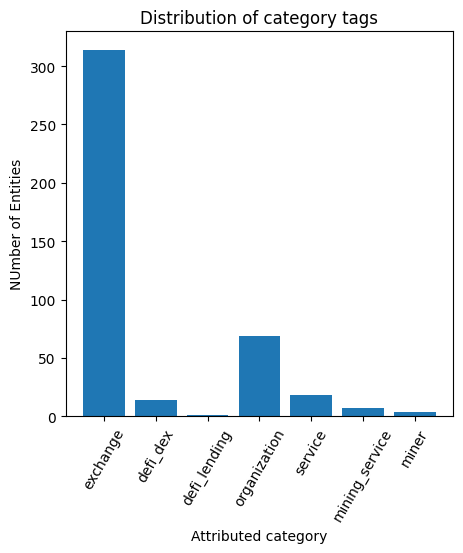

In [14]:
print('Category distribution')
counts = actors_df.categories.value_counts()

values = actors_df.categories.unique()
actual_values = {}
for value in values:
    for v in value.split(", "):
        if not v in actual_values:
            actual_values[v] =0
        actual_values[v] = actual_values[v]+counts[value]

plt.figure(figsize=(5, 5)) 
plt.bar(actual_values.keys(), actual_values.values())
plt.xlabel('Attributed category')
plt.ylabel('NUmber of Entities')
plt.title('Distribution of category tags')
plt.tick_params(axis='x', rotation=60)
plt.savefig('figs/category_tags.png')
plt.show()

Lets see how the jurisdictions are "distributed"

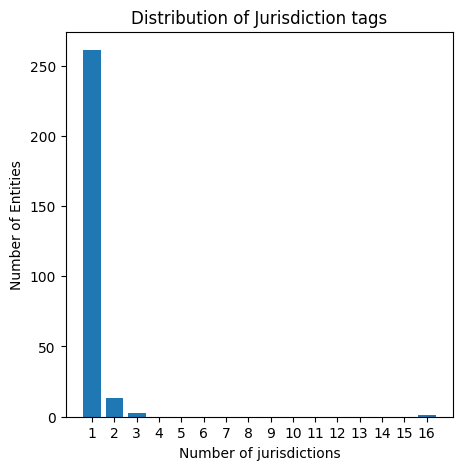

jurisdictions
1     261
2      13
3       3
16      1
Name: count, dtype: int64

In [15]:
# Compute the comma count for each value in the "jurisdictions" column
all_actors_in_flow_data = flows_df.src_id.value_counts().index.union(flows_df.dst_id.value_counts().index)
filtered_actors = actors_df[actors_df.id.str.lower().isin(all_actors_in_flow_data)]
comma_count_stats = filtered_actors['jurisdictions'].apply(lambda x: str(x).count(',')+1).value_counts().sort_index()

plt.figure(figsize=(5, 5)) 
plt.bar(comma_count_stats.index, comma_count_stats.values)
plt.xlabel('Number of jurisdictions')
plt.ylabel('Number of Entities')
plt.xticks(range(1, max(comma_count_stats.index) + 1), range(1, max(comma_count_stats.index) + 1))
plt.title('Distribution of Jurisdiction tags')
plt.savefig('figs/juri_tags.png')
plt.show()

comma_count_stats

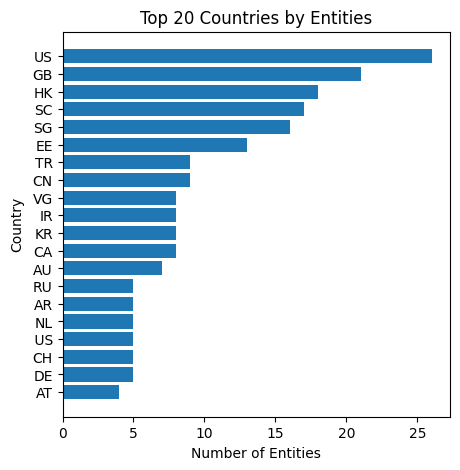

In [16]:
# Check distribution of jurisdictions
actors_jurisdictions = filtered_actors.assign(jurisdictions=filtered_actors.jurisdictions.str.split(','))
actors_jurisdictions = actors_jurisdictions.explode('jurisdictions')
jurisdiction_distribution = actors_jurisdictions.jurisdictions.value_counts().head(20)

plt.figure(figsize=(5, 5)) 
plt.barh(jurisdiction_distribution.index[::-1], jurisdiction_distribution.values[::-1])
plt.xlabel('Number of Entities')
plt.ylabel('Country')
#plt.xticks(range(1, 25), range(1, 25))
plt.title('Top 20 Countries by Entities')
plt.savefig('figs/juri_entities.png')
plt.show()

In which timeframe was the flow data collected?

In [17]:
# Flow data from - to
print(f'Flow data recorded from {flows_df.date.min()} to {flows_df.date.max()}')

Flow data recorded from 2011-05-13 to 2023-04-12


In [18]:
print(f'Flows before merging actor data {flows_df.shape[0]}')
merged_df = pd.merge(filtered_flows_df, actors_df.add_prefix('src_'), on='src_id', how='inner')
merged_df = pd.merge(merged_df, actors_df.add_prefix('dst_'), on='dst_id', how='inner')
print(f'Flows after merging actor data {merged_df.shape[0]}')
display(merged_df.head())

Flows before merging actor data 1939587
Flows after merging actor data 1904481


,src_id,dst_id,value_asset,value_USD,date,src_uri,src_label,src_jurisdictions,src_categories,dst_uri,dst_label,dst_jurisdictions,dst_categories
0,1coin,1coin,36870000,243.755870,2014-03-03,1coin.io,1Coin,"CA, US",exchange,1coin.io,1Coin,"CA, US",exchange
1,1coin,1coin,380120000,2378.899210,2014-03-10,1coin.io,1Coin,"CA, US",exchange,1coin.io,1Coin,"CA, US",exchange
2,1coin,1coin,429150403,2738.687542,2014-03-13,1coin.io,1Coin,"CA, US",exchange,1coin.io,1Coin,"CA, US",exchange
3,1coin,1coin,333900098,2092.574397,2014-03-14,1coin.io,1Coin,"CA, US",exchange,1coin.io,1Coin,"CA, US",exchange
4,1coin,1coin,779334803,4938.373652,2014-03-15,1coin.io,1Coin,"CA, US",exchange,1coin.io,1Coin,"CA, US",exchange


In [19]:
# merge in btc course data
merged_df = pd.merge(merged_df,btc_price_data,on="date",how='inner')

In [20]:
# Types
merged_df['date'] = pd.to_datetime(merged_df['date'])

lets see how much of the traffic is from or to binance

,value_usd_with,value_usd_without,binance portion
year,,,
2011,1.345420e+04,1.345420e+04,0.000000
2012,3.172178e+05,3.172178e+05,0.000000
2013,4.137246e+07,4.137246e+07,0.000000
2014,3.008547e+08,3.008547e+08,0.000000
2015,8.015531e+08,8.015531e+08,0.000000
2016,1.853461e+09,1.853461e+09,0.000000
2017,1.606032e+10,1.447801e+10,9.852298
2018,2.139878e+10,1.502060e+10,29.806291
2019,2.866707e+10,2.417080e+10,15.684417


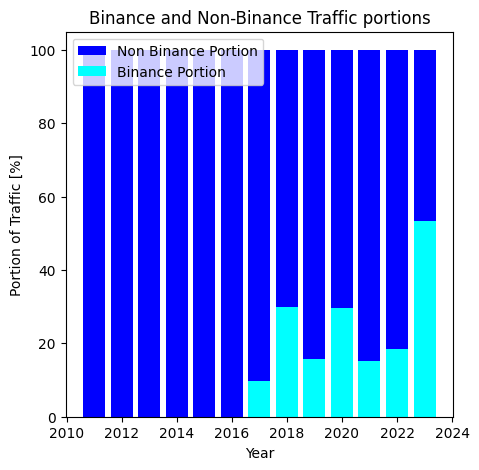

In [21]:
# calc overall traffic per year
yearly = merged_df.groupby(["year"])["value_USD"].sum().reset_index()
yearly.rename(columns={"value_USD":"value_usd_with"},inplace=True)

yearly_without_binance = merged_df[merged_df["src_label"].str.contains("inance") == False]
yearly_without_binance = yearly_without_binance[yearly_without_binance["dst_label"].str.contains("inance") == False]

yearly["value_usd_without"] = yearly_without_binance.groupby(["year"])["value_USD"].sum().reset_index()["value_USD"]
yearly["binance portion"] = (1-(yearly["value_usd_without"]/yearly["value_usd_with"]))*100

yearly.set_index('year',inplace=True)
display(yearly)

# Create a figure and axes
plt.figure(figsize=(5,5))

# Plot the data
plt.bar(yearly.index,100,color='blue',label="Non Binance Portion")
plt.bar(yearly.index, yearly['binance portion'], color='cyan',label="Binance Portion")

# Set labels and title
plt.xlabel('Year')
plt.ylabel('Portion of Traffic [%]')
plt.title('Binance and Non-Binance Traffic portions')

plt.legend(loc='upper left',ncol=1)

# Display the plot
plt.show()

,index,year,value_usd_with,value_usd_without,binance portion,volume
0,0,2011,1.345420e+04,1.345420e+04,0.000000,3.837101e+07
1,1,2012,3.172178e+05,3.172178e+05,0.000000,1.656430e+08
2,2,2013,4.137246e+07,4.137246e+07,0.000000,6.406862e+09
3,3,2014,3.008547e+08,3.008547e+08,0.000000,9.030594e+09
4,4,2015,8.015531e+08,8.015531e+08,0.000000,9.878733e+09
5,5,2016,1.853461e+09,1.853461e+09,0.000000,1.272421e+10
6,6,2017,1.606032e+10,1.447801e+10,9.852298,1.675953e+11
7,7,2018,2.139878e+10,1.502060e+10,29.806291,2.394853e+11
8,8,2019,2.866707e+10,2.417080e+10,15.684417,1.242915e+11
9,9,2020,4.159369e+10,2.928045e+10,29.603633,1.724289e+11


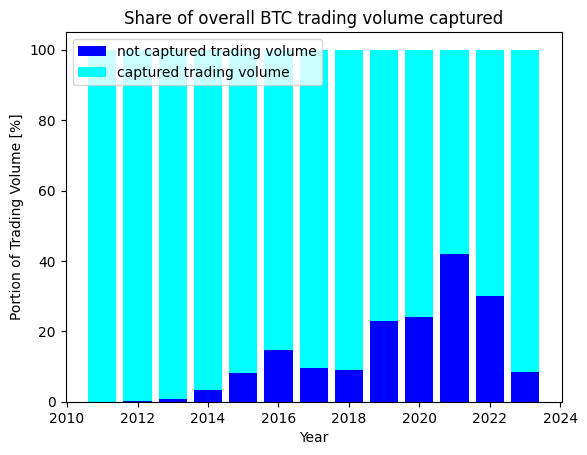

In [22]:
# Compare value per year with overall BTC trading volume
yearly_flow = yearly.copy()
volume_year = trading_volume.groupby(["year"])['volume'].sum().reset_index()
merged_volume = pd.merge(yearly_flow, volume_year, on='year', how='inner').reset_index()

display(merged_volume)

fig, ax = plt.subplots()
bottom = np.zeros(3)
width=0.8

relative_value_flow = merged_volume.value_usd_with / merged_volume.volume
ax.bar(merged_volume.year, relative_value_flow * 100, width, label='not captured trading volume', bottom=0, color='blue')
ax.bar(merged_volume.year, 100 - relative_value_flow * 100, width, label='captured trading volume', bottom=relative_value_flow * 100, color='cyan')

ax.set_title("Share of overall BTC trading volume captured")
plt.ylabel('Portion of Trading Volume [%]')
plt.xlabel('Year')
plt.legend(loc='upper left',ncol=1)

plt.savefig('figs/trading_portion.png')
plt.show()

### Split by juritags

In [23]:
# Transform jurisdiction string into list element
expanded_df = merged_df.copy()
expanded_df.src_jurisdictions = expanded_df.src_jurisdictions.fillna("")
expanded_df.dst_jurisdictions = expanded_df.dst_jurisdictions.fillna("")
expanded_df = expanded_df.assign(src_jurisdictions=expanded_df.src_jurisdictions.str.split(','))
expanded_df = expanded_df.assign(dst_jurisdictions=expanded_df.dst_jurisdictions.str.split(','))

# Split up amounts by number of src and dst countries
expanded_df['value_asset'] = expanded_df.apply(lambda row: row['value_asset'] / max(len(row.src_jurisdictions) * len(row.dst_jurisdictions), 1) , axis=1)
expanded_df['value_USD'] = expanded_df.apply(lambda row: row['value_USD'] / max(len(row.src_jurisdictions) * len(row.dst_jurisdictions), 1), axis=1)

# Create separate columns for each jurisdiction (if we want to split the amounts we have to split amount before)
expanded_df = expanded_df.explode('dst_jurisdictions')
expanded_df = expanded_df.explode('src_jurisdictions')


# Strip whitespace
expanded_df.dst_jurisdictions = expanded_df.dst_jurisdictions.str.strip()
expanded_df.src_jurisdictions = expanded_df.src_jurisdictions.str.strip()

expanded_df_with_inland = expanded_df.copy()
# Remove flows which aren't x-border
expanded_df_without_inland = expanded_df[expanded_df['dst_jurisdictions'] != expanded_df['src_jurisdictions']]

expanded_df = expanded_df[expanded_df['dst_jurisdictions'] != expanded_df['src_jurisdictions']]

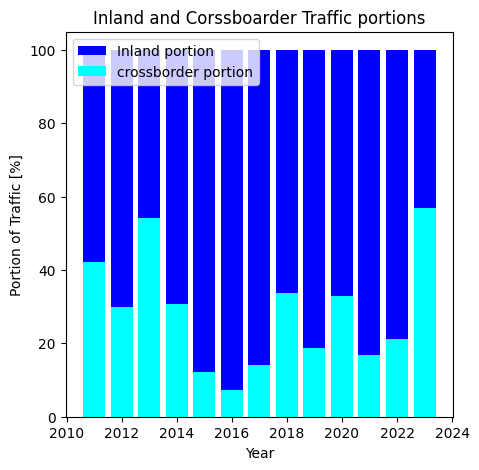

In [24]:
# calc overall traffic per year
yearly = expanded_df_with_inland.groupby(["year"])["value_USD"].sum().reset_index()
yearly.rename(columns={"value_USD":"value_usd_with"},inplace=True)

yearly_without_inland = expanded_df_with_inland[expanded_df_with_inland['dst_jurisdictions'] != expanded_df_with_inland['src_jurisdictions']]
yearly["value_usd_without"] = yearly_without_inland.groupby(["year"])["value_USD"].sum().reset_index()["value_USD"]
yearly["inland portion"] = (1-(yearly["value_usd_without"]/yearly["value_usd_with"]))*100
yearly["crossborder portion"] = (yearly["value_usd_without"]/yearly["value_usd_with"])*100

yearly.set_index('year',inplace=True)

# Create a figure and axes
plt.figure(figsize=(5,5))

# Plot the data
#ax.plot(yearly.index, yearly['inland portion'], color='blue',marker="x",linestyle="dashdot",label="BTC FLOW")
plt.bar(yearly.index,100,color="blue",label="Inland portion")
plt.bar(yearly.index,yearly["crossborder portion"],color="cyan",label="crossborder portion")

# Set labels and title
plt.xlabel('Year')
plt.ylabel('Portion of Traffic [%]')
plt.title('Inland and Corssboarder Traffic portions')

plt.legend(loc='upper left',ncol=1)

# Display the plot
plt.show()

## Split into src and dst dfs

In [25]:
# divide by btc value
# Do we really need this? Isn't value_asset already the number of tokens?
expanded_df["value_BTC"] = expanded_df["value_USD"] / expanded_df["high"]

# Group by year and juristicion
# those are the aggregated recievers
dst_amounts = expanded_df.groupby(['year', 'dst_jurisdictions'])[['value_USD', 'value_asset', 'value_BTC',"src_label","dst_label"]].sum().reset_index()
dst_amounts = dst_amounts.rename(columns={"dst_jurisdictions":"jurisdictions"})
dst_amounts["jurisdictions_long"] = dst_amounts["jurisdictions"].apply(lambda x: juri_names_long[x] if x in juri_names_long else "NOT FOUND")

# this are the aggregated "spenders"
src_amounts = expanded_df.groupby(['year', 'src_jurisdictions'])[['value_USD', 'value_asset', 'value_BTC',"src_label","dst_label"]].sum().reset_index()
src_amounts = src_amounts.rename(columns={"src_jurisdictions":"jurisdictions"})
src_amounts["jurisdictions_long"] = src_amounts["jurisdictions"].apply(lambda x: juri_names_long[x] if x in juri_names_long else "NOT FOUND")

print("small sanity check here ")
print("merged sum "+str(merged_df["value_USD"].sum()/MRD))
print("expanded sum "+str(expanded_df["value_USD"].sum()/MRD))
print("dst sum "+str(dst_amounts["value_USD"].sum()/MRD))
print("src sum "+str(src_amounts["value_USD"].sum()/MRD))

display(dst_amounts)
display(src_amounts)

small sanity check here 
merged sum 496.0505513644367
expanded sum 101.09756828896663
dst sum 101.09756828896658
src sum 101.09756828896658


,year,jurisdictions,value_USD,value_asset,value_BTC,src_label,dst_label,jurisdictions_long
0,2011,AT,3.304020e+02,1.049084e+10,96.264235,Btc-EBtc-EBtc-E,VirwoxVirwoxVirwox,AUSTRIA
1,2011,AU,1.065674e+03,3.370600e+10,337.981765,bitcoin.deVircurexVircurexVircurexVircurexCavi...,Btc-EBtc-EBtc-EBtc-EBtc-EBtc-EBtc-EBtc-EBtc-E,AUSTRALIA
2,2011,BZ,1.498380e+01,3.796239e+08,3.275647,Btc-EVircurexVircurex,VircurexVircurexVircurex,BELIZE
3,2011,CA,4.165230e+02,1.049526e+10,94.021394,Btc-EBtc-EBtc-EBtc-E,CavirtexCavirtexCavirtexCavirtex,CANADA
4,2011,CN,1.498380e+01,3.796239e+08,3.275647,Btc-EVircurexVircurex,VircurexVircurexVircurex,CHINA
...,...,...,...,...,...,...,...,...
528,2023,TW,9.015657e+05,3.509036e+09,37.076293,"Binance (US, DEX)Binance (US, DEX)Binance (US,...",Max MaicoinMax MaicoinMax MaicoinMax MaicoinMa...,"TAIWAN, PROVINCE OF CHINA"
529,2023,US,5.620639e+08,2.423262e+12,25323.154648,"Binance (US, DEX)Binance (US, DEX)Binance (US,...","Binance (US, DEX)Binance (US, DEX)Binance (US,...",UNITED STATES
530,2023,VG,1.220807e+06,4.633253e+09,48.120400,"Binance (US, DEX)Binance (US, DEX)Binance (US,...",LBankLBankLBankLBankLBankLBankLBankLBankLBankL...,"VIRGIN ISLANDS, BRITISH"
531,2023,VN,1.785469e+03,7.432757e+06,0.079321,"Binance (US, DEX)Binance (US, DEX)Binance (US,...",VindaxVindaxVindaxVindaxVindaxVindaxVindaxVind...,VIETNAM


,year,jurisdictions,value_USD,value_asset,value_BTC,src_label,dst_label,jurisdictions_long
0,2011,AT,2.778538e+03,7.049400e+10,609.227868,VirwoxVirwox,BtccTheRockTrading,AUSTRIA
1,2011,AU,8.976231e+02,2.575297e+10,230.117138,Btc-EBtc-EBtc-EBtc-EBtc-EBtc-EBtc-EBtc-EBtc-EB...,CavirtexCavirtexBtccVircurexVircurexVirwoxBitc...,AUSTRALIA
2,2011,BZ,7.378865e+01,1.777978e+09,15.476436,VircurexVircurexVircurexVircurex,Btc-EVircurexBtc-EVircurex,BELIZE
3,2011,CA,5.101930e+01,1.701000e+09,14.056460,CavirtexCavirtexCavirtexCavirtexCavirtex,BitcoinicaBtc-EBtc-EBitcoinicaBitcoinica,CANADA
4,2011,CN,7.378865e+01,1.777978e+09,15.476436,VircurexVircurexVircurexVircurex,Btc-EVircurexBtc-EVircurex,CHINA
...,...,...,...,...,...,...,...,...
505,2023,TR,1.538532e+07,7.013529e+10,733.712939,BtcTurk PROBtcTurk PROBtcTurk PROBtcTurk PROBt...,"BiboxBinance (US, DEX)Binance (US, DEX)Binance...",TURKEY
506,2023,TW,4.401535e+06,1.815027e+10,184.821881,Max MaicoinMax MaicoinMax MaicoinMax MaicoinMa...,"MEXC GlobalBinance (US, DEX)Binance (US, DEX)B...","TAIWAN, PROVINCE OF CHINA"
507,2023,US,3.448535e+08,1.492664e+12,15636.918037,"Binance (US, DEX)CoinbaseBinance (US, DEX)Coin...","CexCexHuobiHuobiHuobiBinance (US, DEX)Binance ...",UNITED STATES
508,2023,VG,5.766492e+04,2.493717e+08,2.537573,BKEXBKEXBKEXBKEXBKEXBKEXBKEXBKEXBKEXBKEXBKEXBK...,"CoinbaseCoinbaseBinance (US, DEX)Binance (US, ...","VIRGIN ISLANDS, BRITISH"


In [26]:
# Number of flows after merging and filtering for different locations
print(f'Number of rows in the flow dataset {merged_df.shape[0]}')

Number of rows in the flow dataset 295758


### Frequency of jurisidictions in the flow data

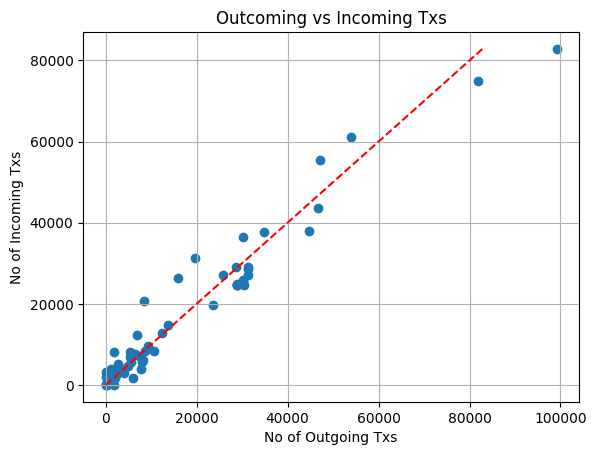

,count_x,count_y
US,99146,82843
SC,81817,74956
GB,53979,61205
SG,47055,55383
MT,46630,43594
...,...,...
DK,144,236
GI,68,3230
VN,58,2034
BE,12,28


,count_x,count_y
US,99146,82843
SC,81817,74956
GB,53979,61205
SG,47055,55383
MT,46630,43594
...,...,...
DK,144,236
GI,68,3230
VN,58,2034
BE,12,28


,count_x,count_y
US,99146,82843
SC,81817,74956
GB,53979,61205
SG,47055,55383
MT,46630,43594
...,...,...
DK,144,236
HR,271,97
BE,12,28
IN,2,14


src_jurisdictions
US    99146
SC    81817
GB    53979
SG    47055
MT    46630
KY    44735
ZA    34714
NZ    31399
IT    31252
LT    31228
Name: count, dtype: int64

dst_jurisdictions
US    82843
SC    74956
GB    61205
SG    55383
MT    43594
KY    38056
ZA    37585
AU    36502
HK    31336
CY    29115
Name: count, dtype: int64

PearsonRResult(statistic=0.9740857437209637, pvalue=1.9463625743427776e-40)

In [27]:
src_juri_freq = expanded_df.src_jurisdictions.value_counts()
dst_juri_freq = expanded_df.dst_jurisdictions.value_counts()
merged_freq = pd.merge(src_juri_freq, dst_juri_freq, left_index=True, right_index=True, how='inner')

plt.scatter(x=merged_freq.count_x, y=merged_freq.count_y)
plt.xlabel('No of Outgoing Txs')
plt.ylabel('No of Incoming Txs')
plt.title('Outcoming vs Incoming Txs')
plt.grid(True)
line = np.linspace(min(merged_freq.count_x), max(merged_freq.count_y), 100)
plt.plot(line, line, color='r', linestyle='--')
plt.savefig('figs/distribution_in_out.png')
plt.show()

display(merged_freq)
display(merged_freq.sort_values(by='count_x', ascending=False))
display(merged_freq.sort_values(by='count_y', ascending=False))
display(src_juri_freq.head(10))
display(dst_juri_freq.head(10))

corr = pearsonr(merged_freq.count_x, merged_freq.count_y)
display(corr)

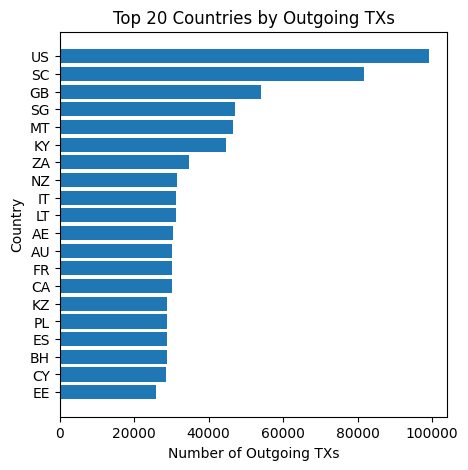

In [28]:
# Plot top 20 in terms of incoming tx
top20_src = src_juri_freq.head(20)
plt.figure(figsize=(5, 5)) 
plt.barh(top20_src.index[::-1], top20_src.values[::-1])
plt.xlabel('Number of Outgoing TXs')
plt.ylabel('Country')
#plt.xticks(range(1, 25), range(1, 25))
plt.title('Top 20 Countries by Outgoing TXs')
plt.savefig('outgoing_top20.png')
plt.show()

### Trading Pairs frequency

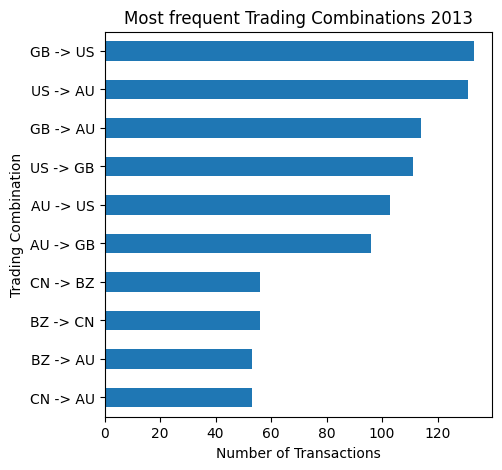

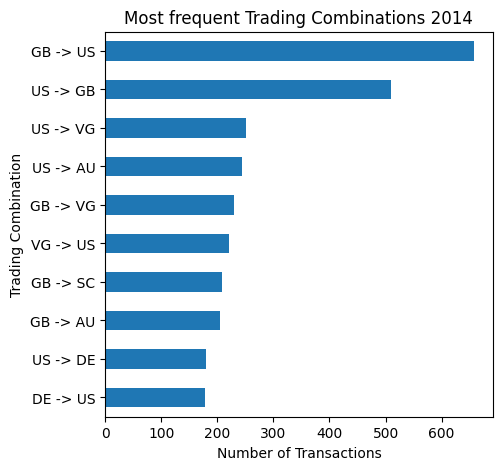

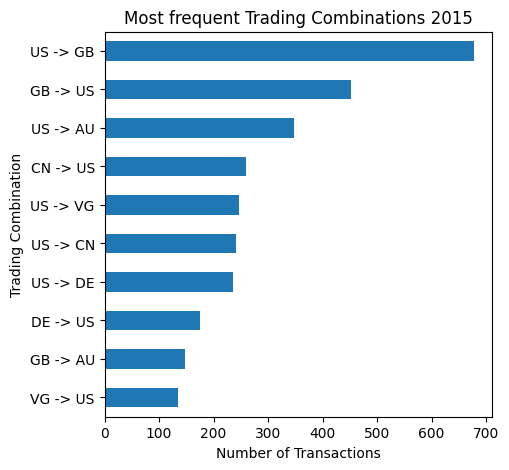

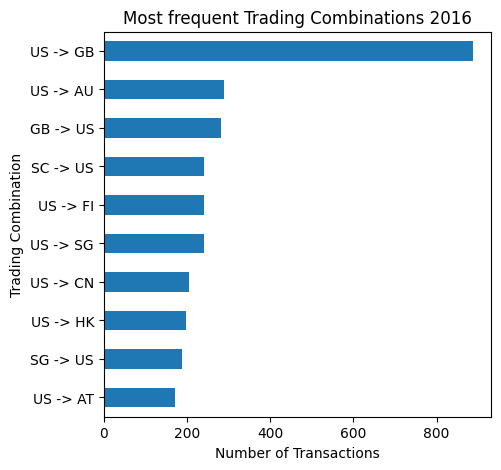

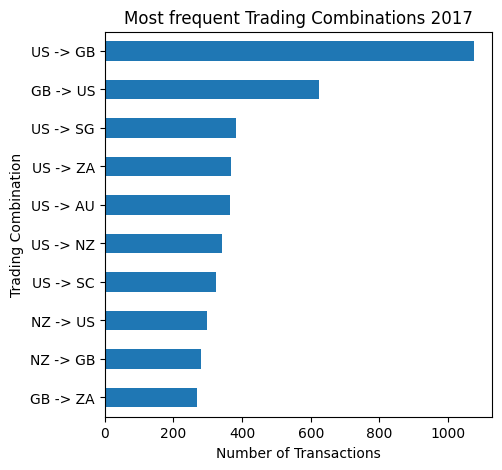

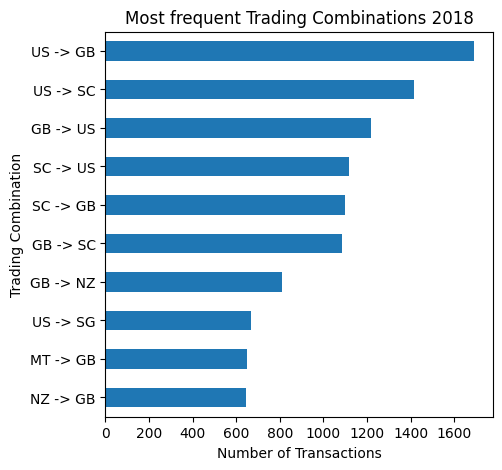

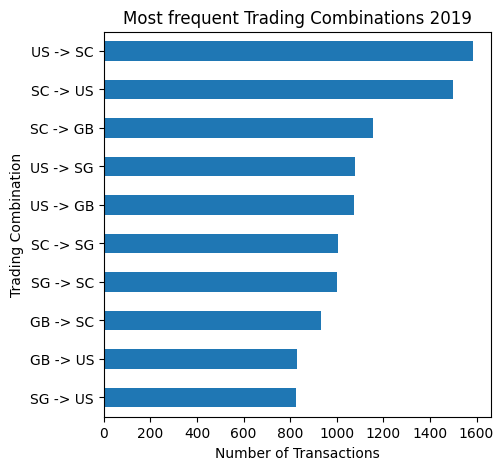

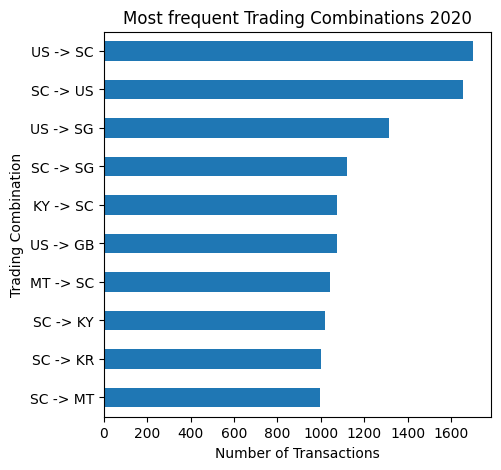

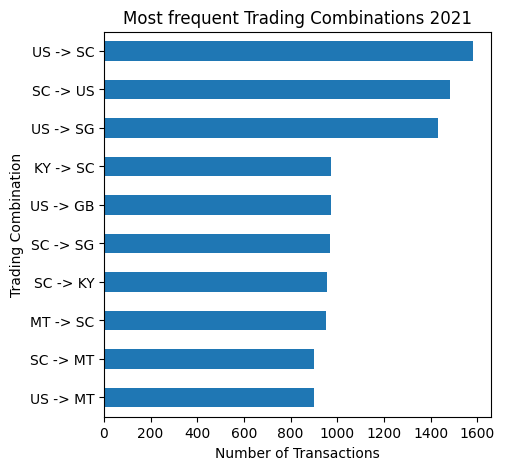

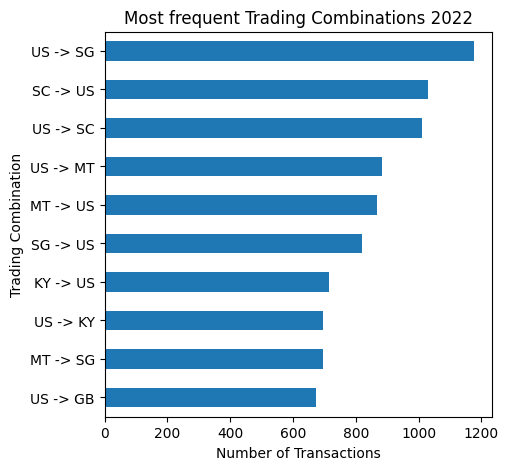

In [29]:
trading_pair_df = expanded_df.copy()
trading_pair_df['trading_pairs'] = trading_pair_df['src_jurisdictions'] + ' -> ' + trading_pair_df['dst_jurisdictions']

# Create a grid of subplots

for year in range(2013, 2023):
    trading_pair_df[trading_pair_df.year == year].trading_pairs.value_counts().head(10)[::-1].plot.barh(figsize=(5, 5))
    plt.xlabel('Number of Transactions')
    plt.ylabel('Trading Combination')
    plt.title(f'Most frequent Trading Combinations {year}')
    plt.savefig(f'figs/trading_combination_{year}.png', bbox_inches='tight')
    plt.show()


In [30]:
display(merged_df)

,src_id,dst_id,value_asset,value_USD,date,src_uri,src_label,src_jurisdictions,src_categories,dst_uri,dst_label,dst_jurisdictions,dst_categories,high,year
0,1coin,1coin,333900098,2092.574397,2014-03-14,1coin.io,1Coin,"CA, US",exchange,1coin.io,1Coin,"CA, US",exchange,461.254980,2014
1,bitfinex,bitfinex,3279364990,20552.001559,2014-03-14,bitfinex.com,Bitfinex,VG,exchange,bitfinex.com,Bitfinex,VG,exchange,461.254980,2014
2,bitstamp,bitfinex,2783769806,17446.072812,2014-03-14,bitstamp.net,Bitstamp,GB,exchange,bitfinex.com,Bitfinex,VG,exchange,461.254980,2014
3,cex,bitfinex,1000000,6.267068,2014-03-14,cex.io,Cex,GB,exchange,bitfinex.com,Bitfinex,VG,exchange,461.254980,2014
4,cryptsy,bitfinex,129885463,814.000978,2014-03-14,cryptsy.com,Cryptsy,US,exchange,bitfinex.com,Bitfinex,VG,exchange,461.254980,2014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295753,virwox,virwox,412000001,36.012922,2011-05-31,virwox.com,Virwox,AT,exchange,virwox.com,Virwox,AT,exchange,8.758259,2011
295754,virwox,virwox,1000000,0.185499,2011-06-06,virwox.com,Virwox,AT,exchange,virwox.com,Virwox,AT,exchange,17.804963,2011
295755,virwox,virwox,12969814,2.271014,2011-06-25,virwox.com,Virwox,AT,exchange,virwox.com,Virwox,AT,exchange,16.543933,2011
295756,virwox,virwox,67982084,9.388327,2011-07-15,virwox.com,Virwox,AT,exchange,virwox.com,Virwox,AT,exchange,13.829063,2011


In [32]:
pairs = expanded_df.copy()

for year in range(2013, 2023):

    grouped_df = pairs[pairs.year == year].groupby(['src_jurisdictions', 'dst_jurisdictions'])['value_USD'].sum()
    src_countries = list(grouped_df.index.get_level_values(0).unique())
    dst_countries = list(grouped_df.index.get_level_values(1).unique())
    all_countries = list(set(src_countries + dst_countries))

    countries_index = {}
    for i, country in enumerate(all_countries):
        countries_index[country] = i

    sources = []
    target = []
    values = []
    text = []
    for element in grouped_df.index:
        src = element[0]
        dst = element[1]
        value = grouped_df[element]
    
        if src == 'US' and value > 10000:
            sources.append(countries_index[src])
            target.append(countries_index[dst] + len(countries_index))
            values.append(value)
            text.append(f'{value}')

    # Sankey Diagram
    fig = go.Figure(data=[go.Sankey(
        node = dict(
          pad = 15,
          thickness = 20,
          line = dict(color = "black", width = 0.5),
          label = all_countries + all_countries,
          color = "gray"
        ),
        link = dict(
          source = sources, # indices correspond to labels, eg A1, A2, A1, B1, ...
          target = target,
          value = values,
      ))])
    fig.update_layout(title_text=f'US Outgoing BTC Flow {year}', font_size=10)
    pio.write_image(fig, f'figs/us_flow{year}.png')
    fig.show()

### How does the general trend look like?

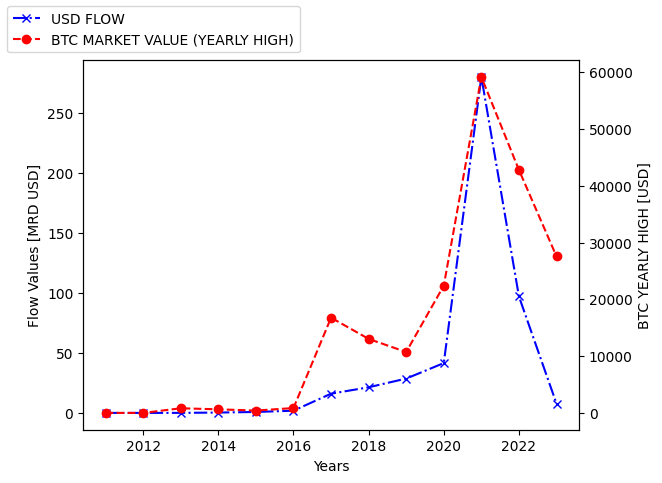

In [98]:
def test_plot(flow_data, btc_data):
    _flow_data = flow_data.groupby('year')["value_USD"].sum()/MRD
    _btc_data = btc_data.groupby('year')["high"].max()

    fig, ax1 = plt.subplots()

    # Plotting the bar plot
    ax1.plot(_flow_data.index, _flow_data.values, color='blue',marker="x",linestyle="dashdot",label="USD FLOW")
    ax1.set_ylabel('Flow Values [MRD USD]')
    ax2 = ax1.twinx()

    # Plotting the line plot
    ax2.plot(_flow_data.index, _btc_data.values, color='red', marker='o', linestyle="dashed",label="BTC MARKET VALUE (YEARLY HIGH)")
    ax2.set_ylabel('BTC YEARLY HIGH [USD]')
    ax1.set_xlabel('Years')
    fig.legend(loc='upper left',ncol=1)

    #plt.tight_layout()

test_plot(src_amounts, btc_price_data)
#test_plot(dst_amounts)

looks like Flow value and the BTC market value correlate - does that mean that the amount of BTC flowing (=flow value/ btc market value) is constant? Lets see

In [99]:
def test_plot2(flow_data,btc_data):
    # TODO: can we use the assets or should we use BTC_value?
    _flow_data = flow_data.groupby('year')["src_value_asset"].sum()/1000000
    _btc_data = btc_data.groupby('year')["high"].max()

    fig, ax1 = plt.subplots()

    # Plotting the bar plot
    ax1.plot(_flow_data.index, _flow_data.values, color='blue',marker="x",linestyle="dashdot",label="BTC FLOW")
    ax1.set_ylabel('Flow Values [MIO BTC]')
    ax2 = ax1.twinx()

    # Plotting the line plot
    ax2.plot(_flow_data.index, _btc_data.values, color='red', marker='o', linestyle="dashed",label="BTC MARKET VALUE (YEARLY HIGH)")
    ax2.set_ylabel('BTC YEARLY HIGH [USD]')
    ax1.set_xlabel('Years')
    fig.legend(loc='upper left',ncol=1)

#test_plot2(src_amounts,btc_price_data)

how are the flows distributed over the jurisdictions?

In [100]:
print(src_amounts["value_USD"].sum()/MRD)
print(dst_amounts["value_USD"].sum()/MRD)
print((src_amounts["value_USD"] - dst_amounts["value_USD"]).sum()/MRD)

496.0505513644367
496.05055136443667
4.116758263151439


Cutoff: 0.6138954343113129


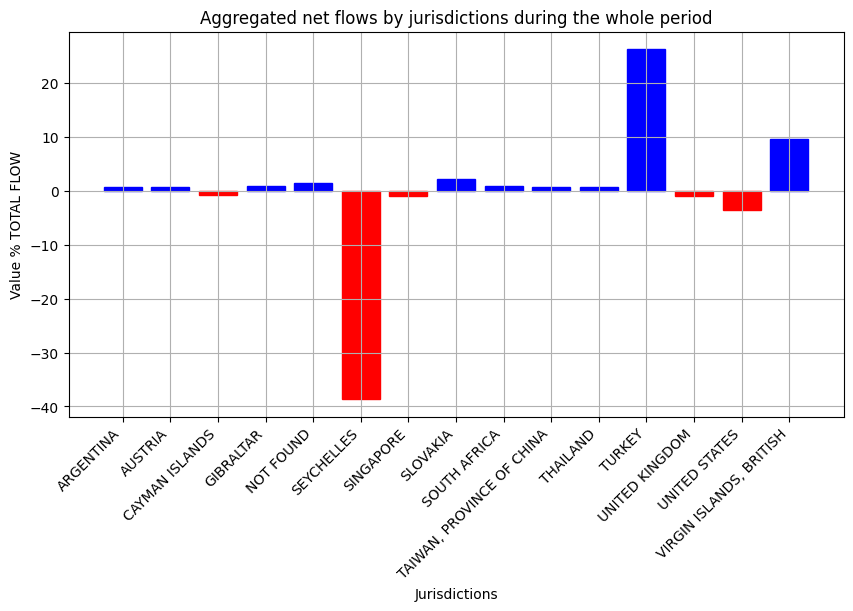

In [101]:
result = src_amounts.copy()
#TODO rethink here why seychells are so negative?? shouldnt they get all the value instead of losing it?
result['value_USD'] = dst_amounts['value_USD'].sub(src_amounts['value_USD'], axis=0)

result = result.groupby(['jurisdictions_long'])['value_USD'].sum().reset_index()
result = result.sort_values("jurisdictions_long",ascending=True)
result["value_USD"] = (result["value_USD"] / result["value_USD"].abs().sum())*100 #convert to %


#filter out the top15
top15_cutoff = float(result["value_USD"].abs().nlargest(15).nsmallest(1).iloc[0])
#print(res["value_USD"].abs().nlargest(15))
print("Cutoff: "+str(top15_cutoff))

result = result[result["value_USD"].abs()>=top15_cutoff]
if(len(result)> 15):
    result.drop(result["value_USD"].idxmin(),inplace=True)

plt.figure(figsize=(10, 5))

# Plot the bar chart
bars = plt.bar(result['jurisdictions_long'], result['value_USD'])

# Set labels and title
plt.xlabel('Jurisdictions')
plt.ylabel('Value % TOTAL FLOW')
plt.title('Aggregated net flows by jurisdictions during the whole period')

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45,ha='right')
plt.grid(True)

# Color the bars based on a condition
for bar, value in zip(bars, result['value_USD']):
    if value < 0:
        bar.set_color('red')
    else:
        bar.set_color('blue')

# Display the plot
plt.show()
#display(result)

interactive(children=(IntSlider(value=2017, description='year', max=2022, min=2012), Output()), _dom_classes=(…

Cutoff: 1.101 % yearly flow
dropping a row
rows after:13
Cutoff: 0.506 % yearly flow
dropping a row
rows after:12
Cutoff: 3.245 % yearly flow
dropping a row
rows after:11
Cutoff: 0.532 % yearly flow
dropping a row
rows after:10
Cutoff: 0.244 % yearly flow
rows after:10
Cutoff: 0.534 % yearly flow
rows after:10
Cutoff: 3.168 % yearly flow
rows after:10
Cutoff: 0.763 % yearly flow
rows after:10
Cutoff: 1.112 % yearly flow
rows after:10
Cutoff: 0.537 % yearly flow
rows after:10
Cutoff: 0.864 % yearly flow
rows after:10


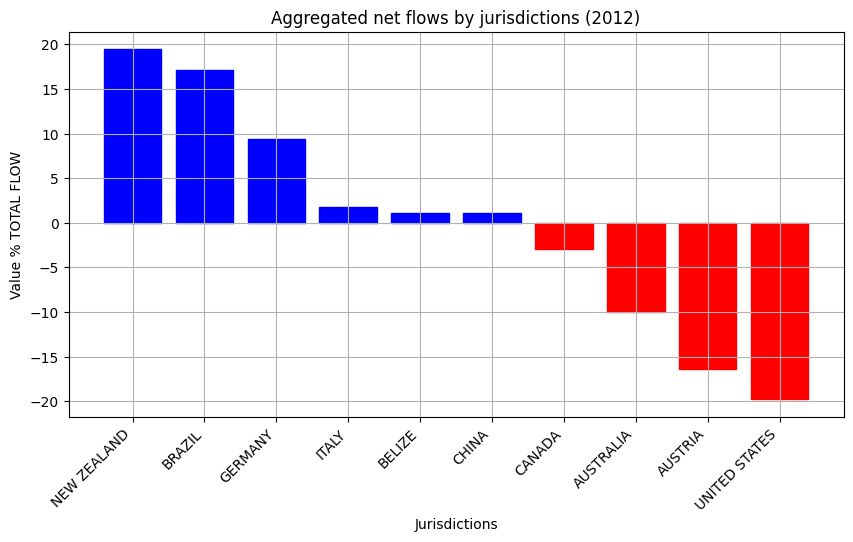

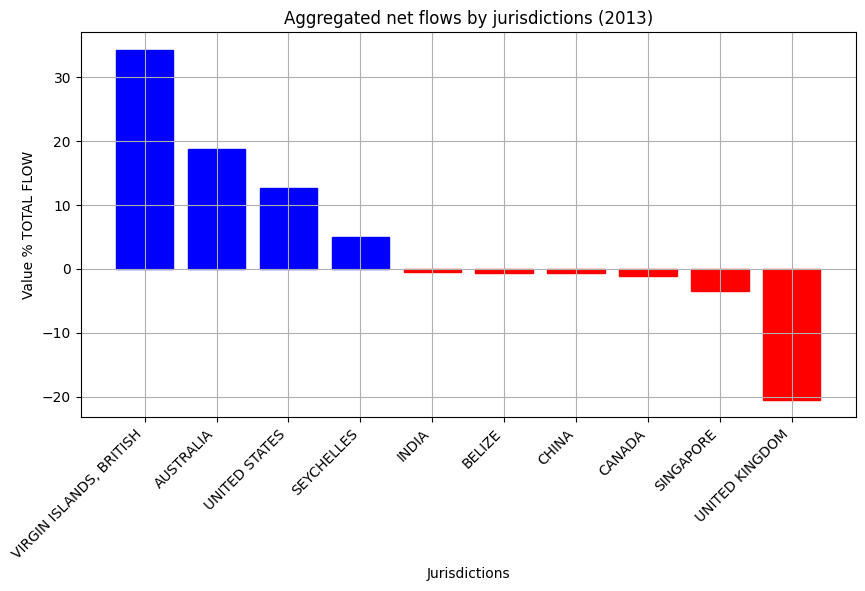

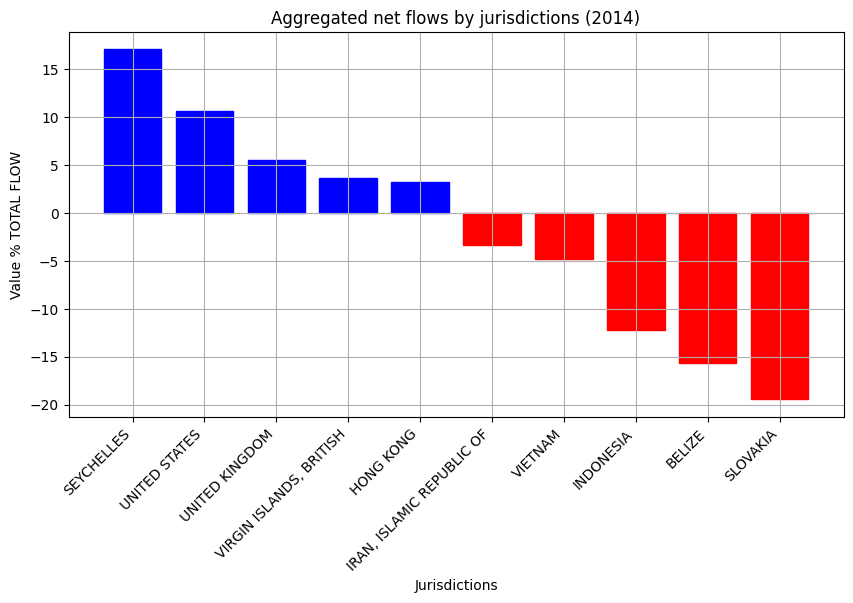

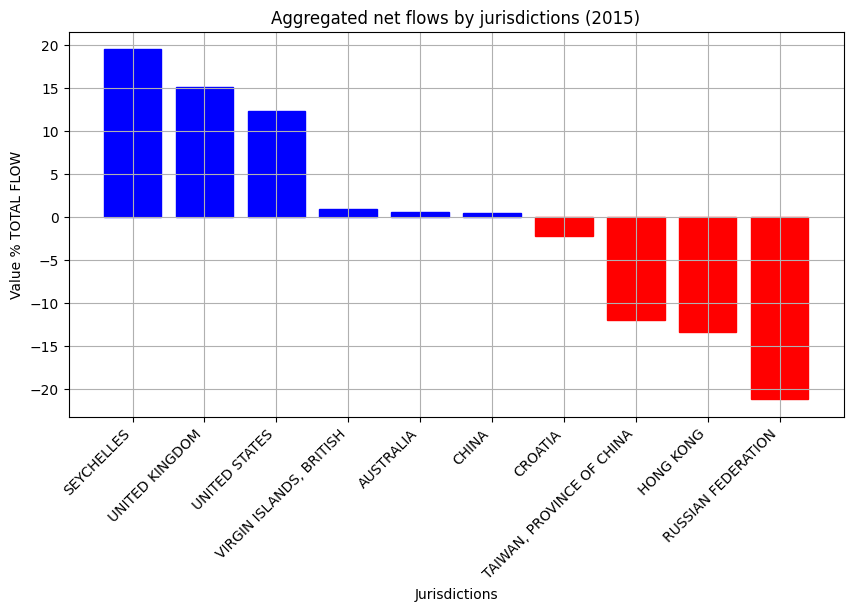

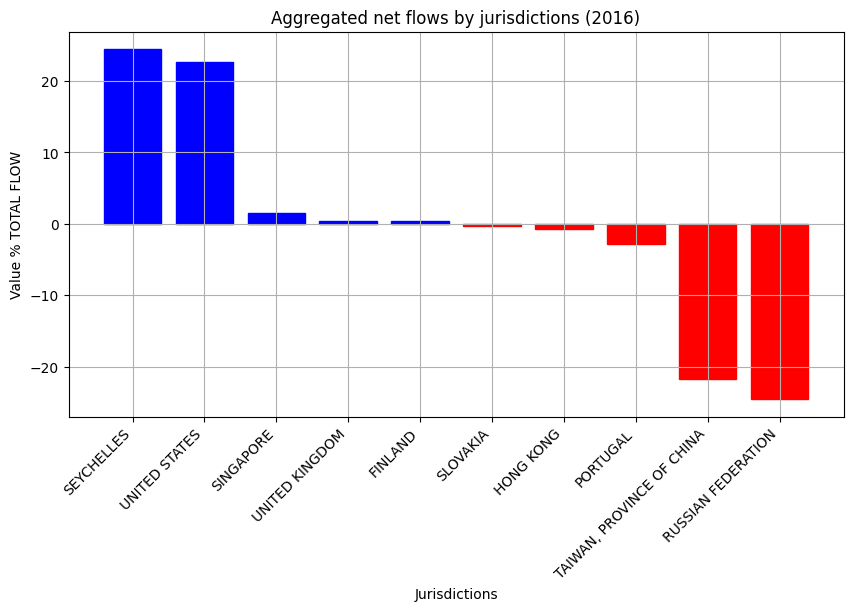

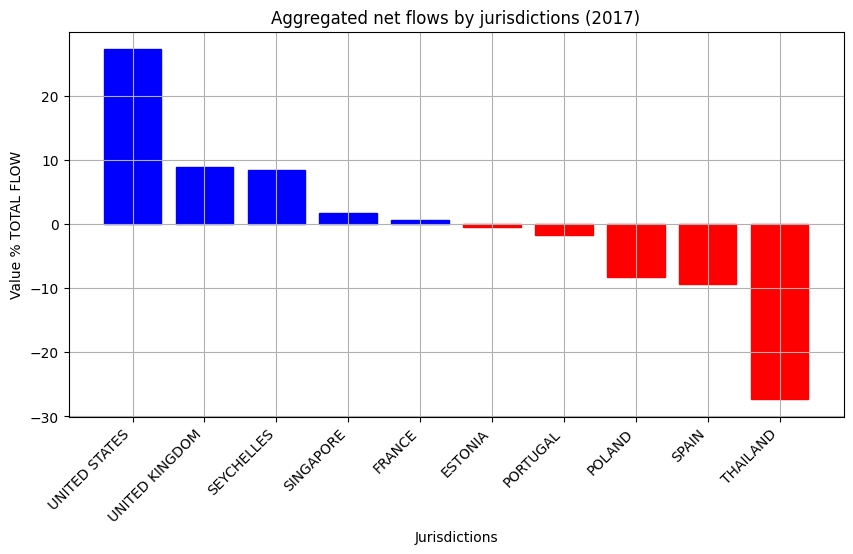

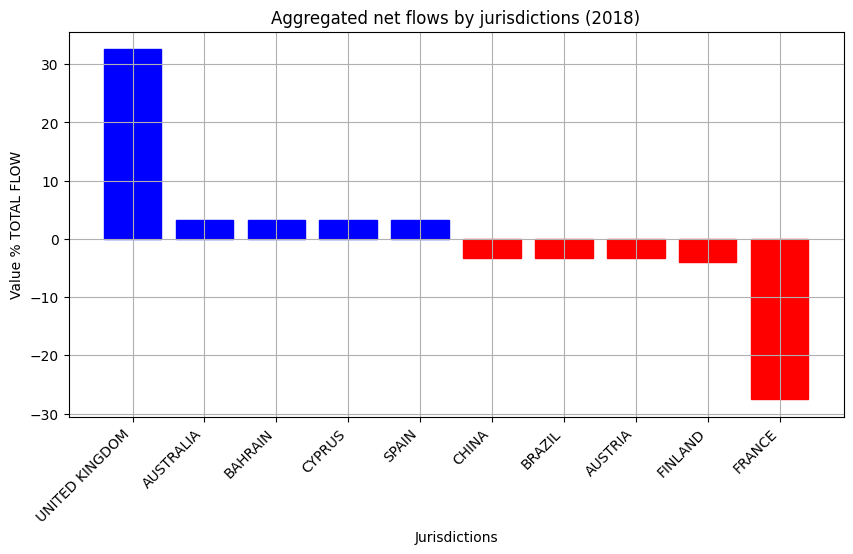

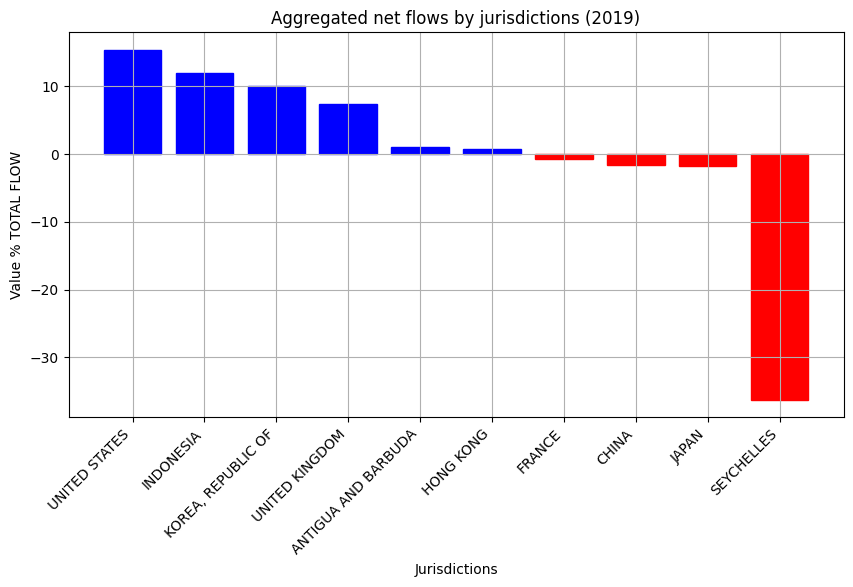

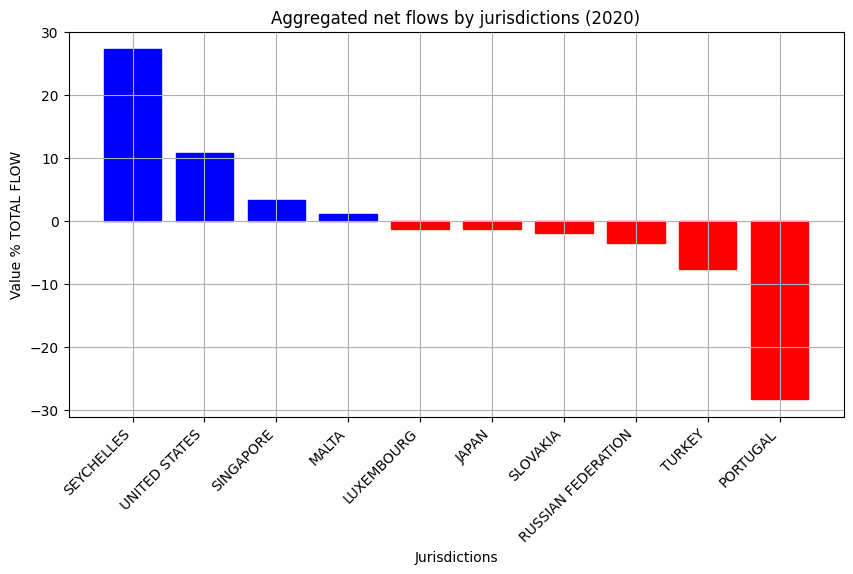

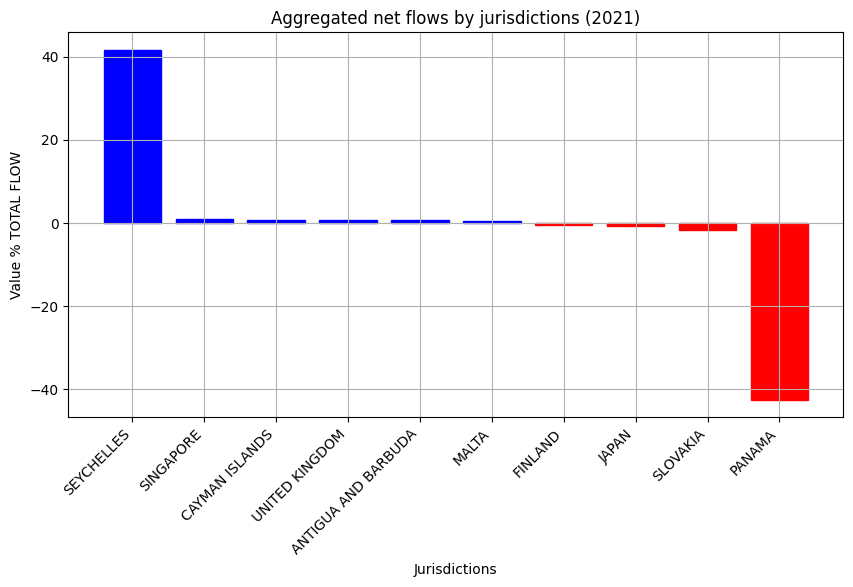

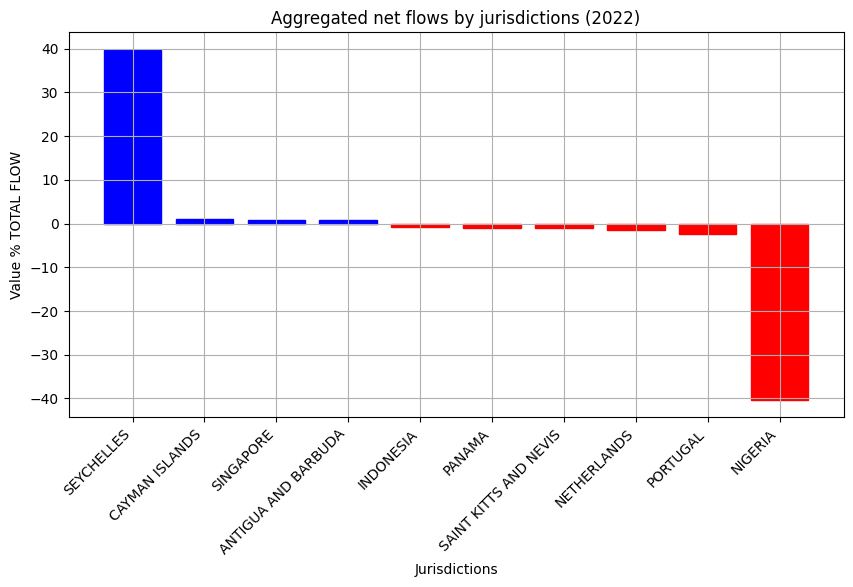

In [102]:
def plot_net_flows_by_year(src_amounts,dst_amounts,year,save):
    _src_amounts = src_amounts.copy()[src_amounts["year"]== year]
    _dst_amounts = dst_amounts.copy()[dst_amounts["year"]== year]

    res = _dst_amounts
    res["value_USD"] = _dst_amounts['value_USD'].sub(_src_amounts['value_USD'], axis=0)
    res = res.groupby(['jurisdictions_long'])['value_USD'].sum().reset_index()

    res = res.sort_values("jurisdictions_long",ascending=True)
    res["value_USD"] =  (res["value_USD"] / res["value_USD"].abs().sum())*100 #convert to %

    #filter out the top10
    top10_cutoff = float(res["value_USD"].abs().nlargest(10).nsmallest(1).iloc[0])#
    #print(res["value_USD"].abs().nlargest(15))
    print("Cutoff: "+str(round(top10_cutoff,3))+" % yearly flow")

    res = res[res["value_USD"].abs()>=top10_cutoff]
    if(len(result)> 10):
        result.drop(result["value_USD"].idxmin(),inplace=True)

    

    res = res.sort_values(by='value_USD',ascending=False)
    plt.figure(figsize=(10, 5))

    # Plot the bar chart
    bars = plt.bar(res['jurisdictions_long'], res['value_USD'])

    # Set labels and title
    plt.xlabel('Jurisdictions')
    plt.ylabel('Value % TOTAL FLOW')
    plt.title('Aggregated net flows by jurisdictions ('+str(year)+')')

    # Rotate x-axis labels for better visibility
    plt.xticks(rotation=45,ha='right')
    plt.grid(True)

    # Color the bars based on a condition
    for bar, value in zip(bars, res['value_USD']):
        if value < 0:
            bar.set_color('red')
        else:
            bar.set_color('blue')

    # Display the plot
    if(save):
        plt.savefig("figs/aggregated_"+str(year),bbox_inches='tight')
    else:  
        plt.show()

interact(plot_net_flows_by_year,src_amounts=fixed(src_amounts),dst_amounts=fixed(dst_amounts),year=(2012,2022,1),save=fixed(False))

for year in range(2012, 2023):
    plot_net_flows_by_year(src_amounts=src_amounts,dst_amounts=dst_amounts,year=year,save=True)

## What do the flows look like on a map?

interactive(children=(IntSlider(value=2017, description='year', max=2022, min=2012), Output()), _dom_classes=(…

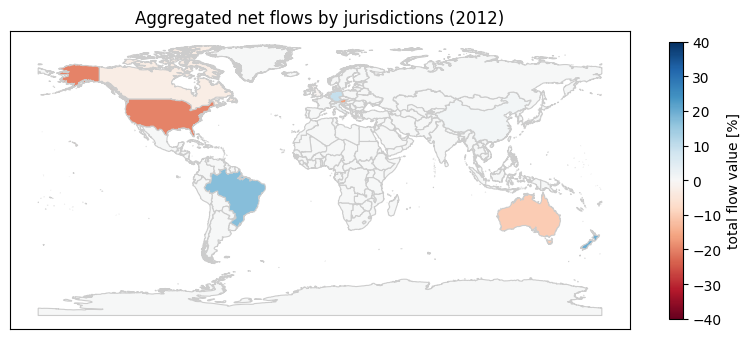

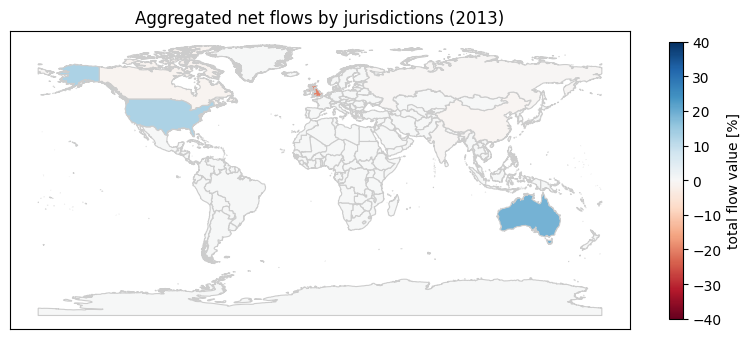

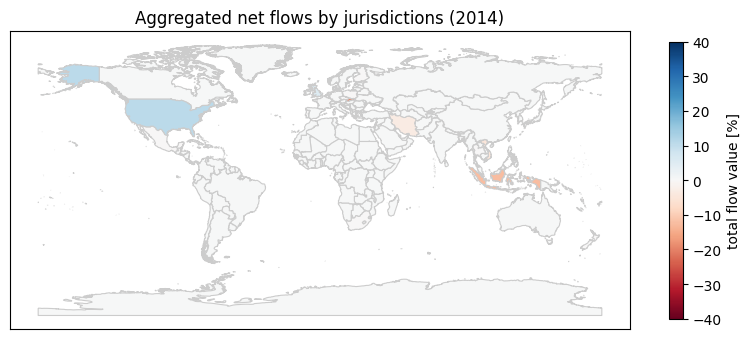

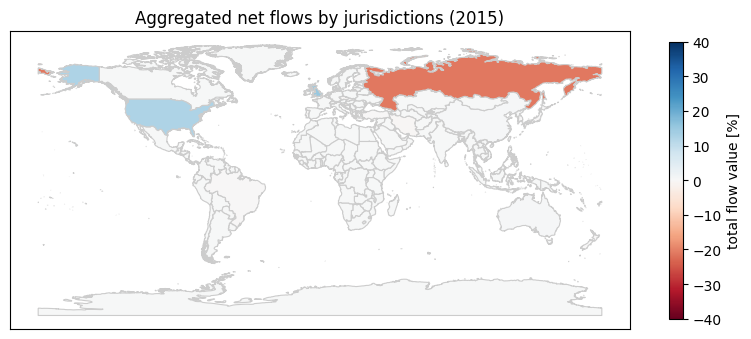

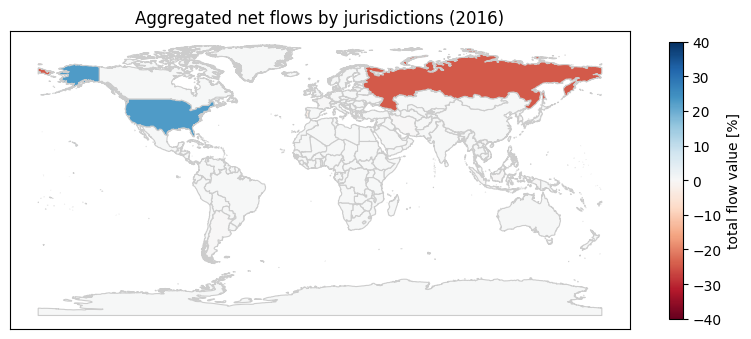

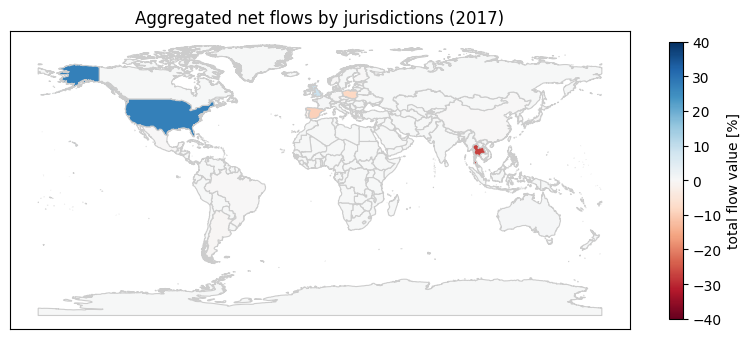

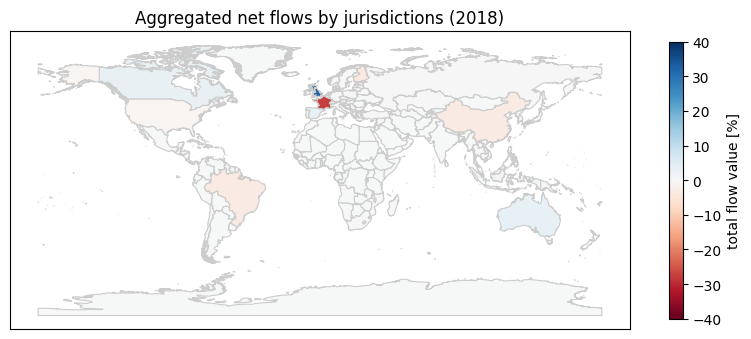

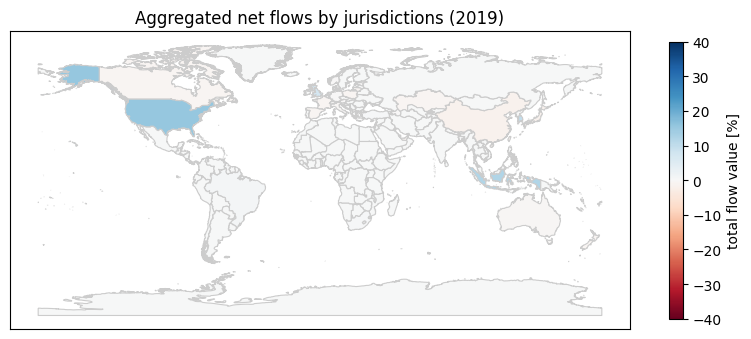

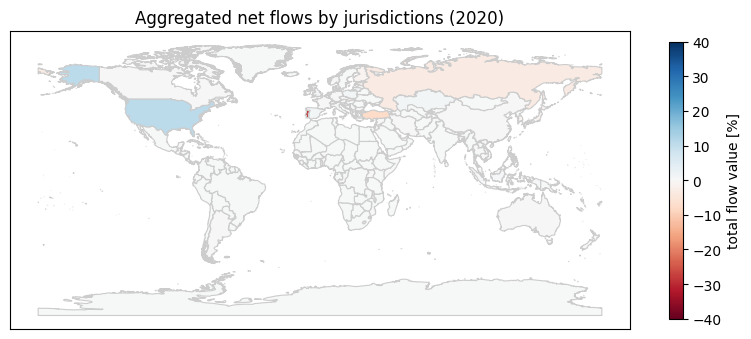

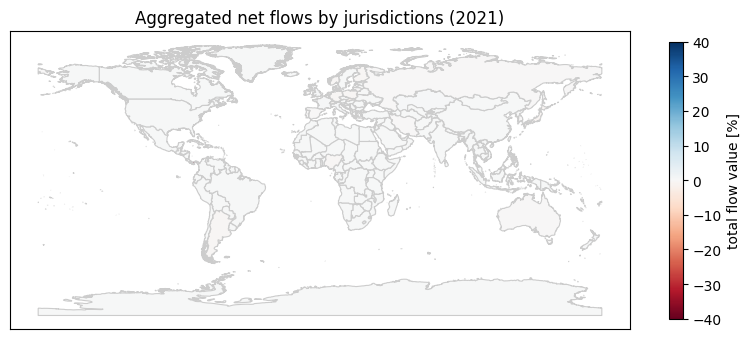

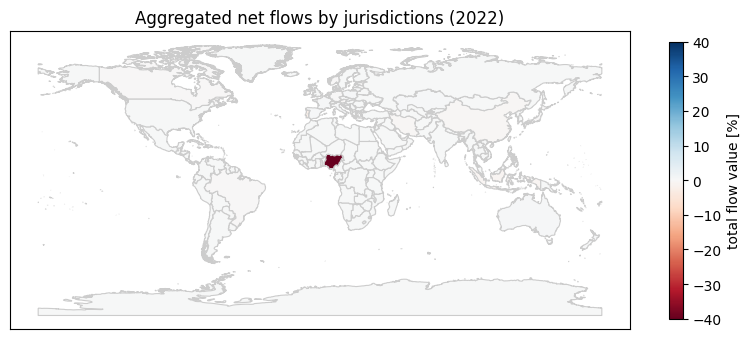

In [103]:
def plot_net_flows_by_year_heatmap(src_amounts,dst_amounts,year,save):
    _src_amounts = src_amounts.copy()[src_amounts["year"]== year]
    _dst_amounts = dst_amounts.copy()[dst_amounts["year"]== year]

    res = _dst_amounts
    res["value_USD"] = _dst_amounts['value_USD'].sub(_src_amounts['value_USD'], axis=0)
    res = res.groupby(['jurisdictions'])['value_USD'].sum().reset_index()

    res = res.sort_values("jurisdictions",ascending=True)
    res["value_USD"] =  (res["value_USD"] / res["value_USD"].abs().sum())*100 #convert to %

    res.rename(columns={'jurisdictions':'alpha-2'},inplace=True)
    country_codes = pd.read_csv('data/country_codes.csv')
    country_codes = country_codes[['alpha-2','alpha-3']]

    c_merged_df= pd.merge(res, country_codes,on='alpha-2',how='left')
    c_merged_df = c_merged_df.fillna(0)
    c_merged_df.rename(columns={'alpha-2':'ISO'},inplace=True)
    map_data = gpd.read_file('shapefile/World_Countries__Generalized_.shp')
    c_merged_data = map_data.merge(c_merged_df, on='ISO',how='left')
    c_merged_data = c_merged_data.fillna(0)

    # normalize color
    vmin, vmax, vcenter = -40, 40, 0
    norm = TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
    
    # create a normalized colorbar
    cmap = 'RdBu'
    cbar = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    
    fig, ax = plt.subplots(figsize=(10, 8))

    c_merged_data.plot(column='value_USD', cmap=cmap, linewidth=0.8, ax=ax, edgecolor='0.8', legend=False,norm=norm)
    fig.colorbar(cbar,ax=ax,shrink=0.45,label="total flow value [%]")

    plt.xticks([])
    plt.yticks([])
    plt.title('Aggregated net flows by jurisdictions ('+str(year)+')')

    # Display the plot
    if(save):
        plt.savefig("figs/heatmap_"+str(year),bbox_inches='tight')
    else:  
        plt.show()
    plt.show()

interact(plot_net_flows_by_year_heatmap,src_amounts=fixed(src_amounts),dst_amounts=fixed(dst_amounts),year=(2012,2022,1),save=fixed(False))

for year in range(2012,2023,1):
    plot_net_flows_by_year_heatmap(src_amounts=src_amounts,dst_amounts=dst_amounts,year=year,save=True)

In [104]:
# TODO: Merge with GDP Data
# TODO: DELETE THIS????
'''
# Merge country codes first
print(f'Dest Rows before merge: {dst_amounts.shape[0]}')
dst = pd.merge(dst_amounts, country_codes[['alpha-2', 'alpha-3', 'region', 'sub-region']], left_on='dst_jurisdictions', right_on='alpha-2', how='left')

print(f'Src rows before merge: {src_amounts.shape[0]}')
src = pd.merge(src_amounts, country_codes[['alpha-2', 'alpha-3', 'region', 'sub-region']], left_on='src_jurisdictions', right_on='alpha-2', how='inner')
#display(src.head())

# Now merge gdp data
dst = pd.merge(dst, gdp, left_on='alpha-3', right_on='Country Code', how='left')
print(f'Dest rows after merge: {dst.shape[0]}')

src = pd.merge(src, gdp, left_on='alpha-3', right_on='Country Code', how='inner')
print(f'Src rows after merge: {src.shape[0]}')

print(display(dst[dst['alpha-3'].isna()]))
'''

"\n# Merge country codes first\nprint(f'Dest Rows before merge: {dst_amounts.shape[0]}')\ndst = pd.merge(dst_amounts, country_codes[['alpha-2', 'alpha-3', 'region', 'sub-region']], left_on='dst_jurisdictions', right_on='alpha-2', how='left')\n\nprint(f'Src rows before merge: {src_amounts.shape[0]}')\nsrc = pd.merge(src_amounts, country_codes[['alpha-2', 'alpha-3', 'region', 'sub-region']], left_on='src_jurisdictions', right_on='alpha-2', how='inner')\n#display(src.head())\n\n# Now merge gdp data\ndst = pd.merge(dst, gdp, left_on='alpha-3', right_on='Country Code', how='left')\nprint(f'Dest rows after merge: {dst.shape[0]}')\n\nsrc = pd.merge(src, gdp, left_on='alpha-3', right_on='Country Code', how='inner')\nprint(f'Src rows after merge: {src.shape[0]}')\n\nprint(display(dst[dst['alpha-3'].isna()]))\n"

# Locality


In [105]:
# Note this is WIP

In [106]:
'''
neighbours = pd.read_csv('data/neighbour_distance_matrix.csv', index_col=0, delimiter=';', na_values='NAN')
pd.set_option('display.max_rows', None)

locality_with_inland = expanded_df_with_inland.copy()
locality_with_inland["value_BTC"] = locality_with_inland["value_USD"] / locality_with_inland["high"]
locality_with_inland = locality_with_inland[locality_with_inland['dst_jurisdictions'] != ""]
locality_with_inland = locality_with_inland[locality_with_inland['src_jurisdictions'] != ""]


locality_without_inland = expanded_df_without_inland.copy() # TODO
locality_without_inland["value_BTC"] = locality_without_inland["value_USD"] / locality_without_inland["high"]


locality_with_inland = locality_with_inland.drop(['src_id','dst_id','src_uri','dst_uri','src_label','dst_label','src_categories','dst_categories','date','high'],axis=1)
locality_with_inland = locality_with_inland.groupby(['year', 'src_jurisdictions','dst_jurisdictions'])[['value_USD', 'value_asset', 'value_BTC']].sum().reset_index()
locality_with_inland['src_jurisdictions_long'] = locality_with_inland['src_jurisdictions'].apply(lambda x: juri_names_long[x] if x in juri_names_long else "NOT FOUND")
locality_with_inland['dst_jurisdictions_long'] = locality_with_inland['dst_jurisdictions'].apply(lambda x: juri_names_long[x] if x in juri_names_long else "NOT FOUND")
locality_with_inland = locality_with_inland[(locality_with_inland['src_jurisdictions_long'] != 'HONG KONG') & (locality_with_inland['src_jurisdictions_long'] != 'TAIWAN, PROVINCE OF CHINA') & (locality_with_inland['src_jurisdictions_long'] != 'VIRGIN ISLANDS, BRITISH')]
locality_with_inland = locality_with_inland[(locality_with_inland['dst_jurisdictions_long'] != 'HONG KONG') & (locality_with_inland['dst_jurisdictions_long'] != 'TAIWAN, PROVINCE OF CHINA') & (locality_with_inland['dst_jurisdictions_long'] != 'VIRGIN ISLANDS, BRITISH')]
locality_with_inland['proportion'] = locality_with_inland['value_USD'] / src_amounts[(src_amounts['jurisdictions'] == locality_with_inland['src_jurisdictions'].values) & (src_amounts['year'] == locality_with_inland['year'].values)].values


def plot_locality(data, neighbours, year, jumps):
    data = data[data['year'] == year]
    data = data[(neighbours[data['src_jurisdictions_long']][data['dst_jurisdictions_long']] >= jumps)]
allowed_values = [1, 3, 5, 10]
interact(plot_locality,data=fixed(locality_with_inland),neighbours=fixed(neighbours),year=(2012,2022,1),jumps=partial(lambda values, v: values[v], allowed_values))

plot_locality(locality_with_inland,neighbours,2016,3)

'''


'\nneighbours = pd.read_csv(\'data/neighbour_distance_matrix.csv\', index_col=0, delimiter=\';\', na_values=\'NAN\')\npd.set_option(\'display.max_rows\', None)\n\nlocality_with_inland = expanded_df_with_inland.copy()\nlocality_with_inland["value_BTC"] = locality_with_inland["value_USD"] / locality_with_inland["high"]\nlocality_with_inland = locality_with_inland[locality_with_inland[\'dst_jurisdictions\'] != ""]\nlocality_with_inland = locality_with_inland[locality_with_inland[\'src_jurisdictions\'] != ""]\n\n\nlocality_without_inland = expanded_df_without_inland.copy() # TODO\nlocality_without_inland["value_BTC"] = locality_without_inland["value_USD"] / locality_without_inland["high"]\n\n\nlocality_with_inland = locality_with_inland.drop([\'src_id\',\'dst_id\',\'src_uri\',\'dst_uri\',\'src_label\',\'dst_label\',\'src_categories\',\'dst_categories\',\'date\',\'high\'],axis=1)\nlocality_with_inland = locality_with_inland.groupby([\'year\', \'src_jurisdictions\',\'dst_jurisdictions\'])[[\

# Correlations

In [107]:
# Prepare Population
population_country = pd.merge(population, country_codes, left_on='Country Code', right_on='alpha-3', how='inner')

In [108]:
#TODO FIX THIS
#NameError: name 'population_country' is not defined

flow_data = merged_df.copy()
dst_juri_sum = merged_df.groupby('dst_jurisdictions')['value_USD'].sum()
population_gdp = pd.merge(dst_juri_sum, population_country, left_on='dst_jurisdictions', right_on='alpha-2', how='inner')
'''
fig, ax = plt.subplots()
scatter = ax.scatter(x=np.log10(population_gdp.dst_value_USD), y=population_gdp['2021'])
plt.xlabel('Received USD')
plt.ylabel('Population')
plt.title('Population / Received USD')
plt.grid(True)

corr = pearsonr(population_gdp.dst_value_USD, population_gdp['2021'])
display(corr)
corr = spearmanr(population_gdp.dst_value_USD, population_gdp['2021'])
display(corr)
'''

"\nfig, ax = plt.subplots()\nscatter = ax.scatter(x=np.log10(population_gdp.dst_value_USD), y=population_gdp['2021'])\nplt.xlabel('Received USD')\nplt.ylabel('Population')\nplt.title('Population / Received USD')\nplt.grid(True)\n\ncorr = pearsonr(population_gdp.dst_value_USD, population_gdp['2021'])\ndisplay(corr)\ncorr = spearmanr(population_gdp.dst_value_USD, population_gdp['2021'])\ndisplay(corr)\n"

## TAX HAVEN VS RECIEVED

In [109]:
# Prepare tax haven data
cthi_country = pd.merge(cthi, country_codes, left_on='Country', right_on='name', how='inner')

PearsonRResult(statistic=0.08017090335718623, pvalue=0.6736568668063169)

SignificanceResult(statistic=0.2503059310182336, pvalue=0.18217786492655752)

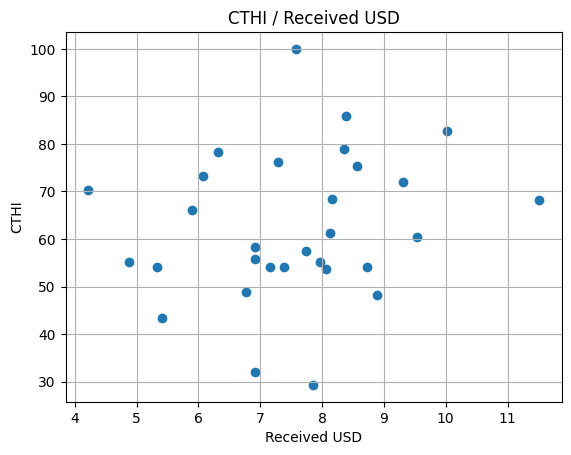

In [110]:
# CTHI (Tax Haven Score)
# TODO UNITS ON AXED also maybe scale to BN USD? 
flow_data = merged_df.copy()
dst_juri_sum = merged_df.groupby('dst_jurisdictions')['value_USD'].sum()
receivers_cthi = pd.merge(dst_juri_sum, cthi_country, left_on='dst_jurisdictions', right_on='alpha-2', how='inner')

fig, ax = plt.subplots()
scatter = ax.scatter(x=np.log10(receivers_cthi.value_USD), y=receivers_cthi['Haven Score'])
plt.xlabel('Received USD')
plt.ylabel('CTHI')
plt.title('CTHI / Received USD')
plt.grid(True)
corr = pearsonr(receivers_cthi.value_USD, receivers_cthi['Haven Score'])
display(corr)

corr = spearmanr(receivers_cthi.value_USD, receivers_cthi['Haven Score'])
display(corr)


## TAX HAVEN VS SENT
TODO

## CORRUPTION VS RECIEVED

In [111]:
# Prepare CPI
cpi_country = pd.merge(cpi, country_codes, left_on='Country', right_on='name', how='inner')

PearsonRResult(statistic=-0.01896782756787657, pvalue=0.6976250174329479)

SignificanceResult(statistic=-0.06423808089556211, pvalue=0.1878164516320307)

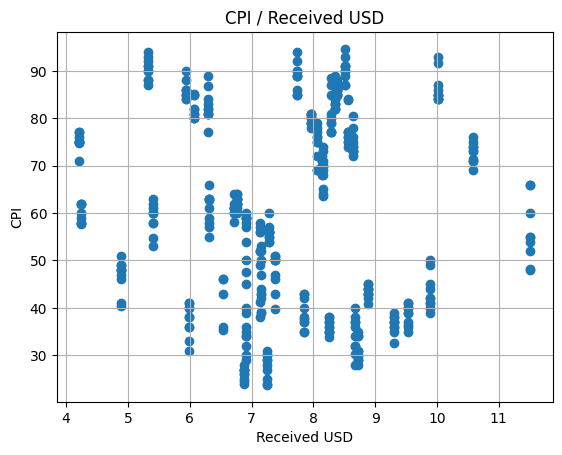

In [112]:
# TODO UNITS ON AXED also maybe scale to BN USD? 
flow_data = merged_df.copy()
dst_juri_sum = merged_df.groupby('dst_jurisdictions')['value_USD'].sum()
receivers_cpi = pd.merge(dst_juri_sum, cpi_country, left_on='dst_jurisdictions', right_on='alpha-2', how='inner')

fig, ax = plt.subplots()
scatter = ax.scatter(x=np.log10(receivers_cpi.value_USD), y=receivers_cpi['CPI Score'])
plt.xlabel('Received USD')
plt.ylabel('CPI')
plt.title('CPI / Received USD')
plt.grid(True)

corr = pearsonr(receivers_cpi.value_USD, receivers_cpi['CPI Score'])
display(corr)
corr = spearmanr(receivers_cpi.value_USD, receivers_cpi['CPI Score'])
display(corr)

## CORRUPTION VS SENT
TODO

## GDP VS RECIEVED

In [113]:
# Prepare GDP
gdp_country = pd.merge(gdp, country_codes, left_on='Country Code', right_on='alpha-3', how='inner')

PearsonRResult(statistic=0.2595805508572278, pvalue=0.05802359861135725)

SignificanceResult(statistic=0.32334667429007047, pvalue=0.017080916012177486)

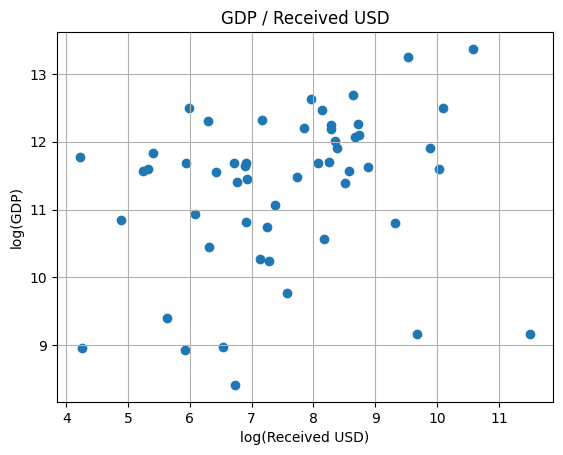

In [114]:
flow_data = merged_df.copy()
dst_juri_sum = merged_df.groupby('dst_jurisdictions')['value_USD'].sum()
receivers_gdp = pd.merge(dst_juri_sum, gdp_country, left_on='dst_jurisdictions', right_on='alpha-2', how='inner')
receivers_gdp = receivers_gdp.dropna(subset=['2021'])

fig, ax = plt.subplots()
scatter = ax.scatter(x=np.log10(receivers_gdp.value_USD), y=np.log10(receivers_gdp['2021']))
plt.xlabel('log(Received USD)')
plt.ylabel('log(GDP)')
plt.title('GDP / Received USD')
plt.grid(True)

corr = pearsonr(np.log10(receivers_gdp.value_USD), np.log10(receivers_gdp['2021']))
display(corr)
corr = spearmanr(receivers_gdp.value_USD, receivers_gdp['2021'])
display(corr)

## GDP VS Sent

PearsonRResult(statistic=0.20676789511548024, pvalue=0.13741022340541503)

SignificanceResult(statistic=0.29180777293984844, pvalue=0.033996025153924525)

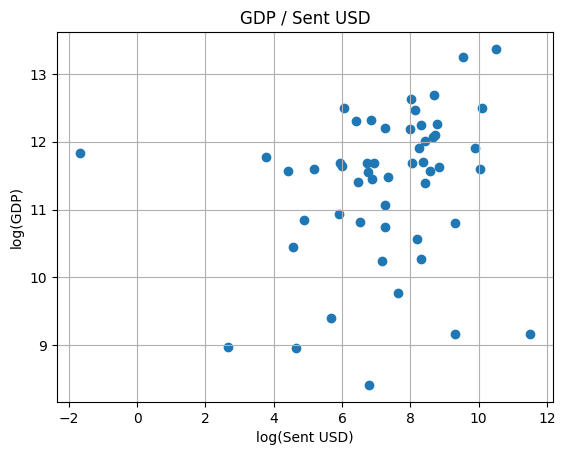

In [115]:
# TODO: why to we have one negative outlier?
flow_data = merged_df.copy()
src_juri_sum = merged_df.groupby('src_jurisdictions')['value_USD'].sum()
receivers_gdp = pd.merge(src_juri_sum, gdp_country, left_on='src_jurisdictions', right_on='alpha-2', how='inner')
receivers_gdp = receivers_gdp.dropna(subset=['2021'])

fig, ax = plt.subplots()
scatter = ax.scatter(x=np.log10(receivers_gdp.value_USD), y=np.log10(receivers_gdp['2021']))
plt.xlabel('log(Sent USD)')
plt.ylabel('log(GDP)')
plt.title('GDP / Sent USD')
plt.grid(True)

corr = pearsonr(np.log10(receivers_gdp.value_USD), np.log10(receivers_gdp['2021']))
display(corr)
corr = spearmanr(receivers_gdp.value_USD, receivers_gdp['2021'])
display(corr)